# Pattern Recognition

In this lab you will experiment with two classic pattern recognition algorithms: Hough Transform (pronounced "huff") and Random Sample Consensus (RANSAC).

Our goal will be to estimate a 2D translational movement of the camera from SIFT feature correspondences.

In [26]:
import matplotlib.pyplot as plt

import numpy as np
import imageio
import skimage
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matched_features, SIFT

First we load the two book images, extract SIFT features and match them.

In [27]:
img1 = rgb2gray(imageio.imread('book1.jpg'))
img2 = rgb2gray(imageio.imread('book2.jpg'))

/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_26302/2952376325.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = rgb2gray(imageio.imread('book1.jpg'))
/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_26302/2952376325.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = rgb2gray(imageio.imread('book2.jpg'))


In [28]:
descriptor_extractor = SIFT()

In [29]:
descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

In [30]:
descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [31]:
matches12 = match_descriptors(
    descriptors1, descriptors2, max_ratio=0.7, cross_check=True
)

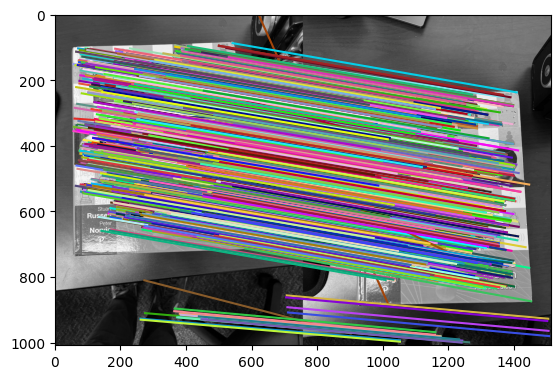

In [32]:
fig,ax = plt.subplots()
plot_matched_features(image0=img1, image1=img2, ax=ax, keypoints0=keypoints1, keypoints1=keypoints2,
                        matches=matches12, only_matches=True)

Now let's compute the motion vector of each feature correspondence.

In [33]:
vecs = keypoints2[matches12[:,1]] - keypoints1[matches12[:,0]]

For simplicity's sake we will only keep the vectors with positive movement.

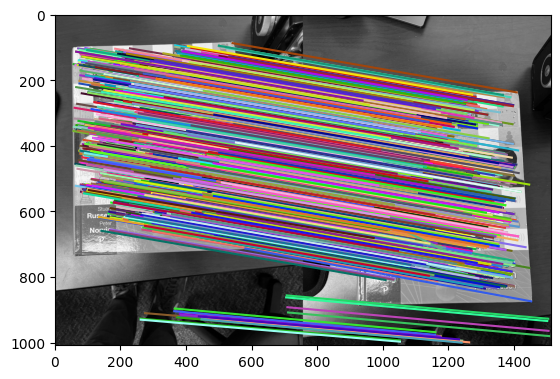

In [34]:
good = (vecs[:,1]>=0) & (vecs[:,0]>=0)
vecs = vecs[good]
matches12 = matches12[good]

fig,ax = plt.subplots()
plot_matched_features(image0=img1, image1=img2, ax=ax, 
                      keypoints0=keypoints1, keypoints1=keypoints2, 
                      matches=matches12, only_matches=True)

1. Now you will build a Hough accumulator to find the dominant motion in this data.

We are trying to estimate a 2D translation, so the Hough accumulator should have two dimensions.  The first dimension is for the Y component of the translation, and the second dimension is for the X dimension of the translation.

Make an accumulator of shape $500\times500$, filled with zeros.  Assume that each grid cell has a size of 1 pixel by 1 pixel.

In [35]:
acc = np.zeros((500, 500), dtype=int)

For each motion vector, add a 1 to the accumulator at the appropriate location.

*Note: Do this using a for loop -- I am not sure if it is possible to do it without a for loop.*

In [36]:
for dy, dx in vecs:
    iy = int(dy)
    ix = int(dx)
    if 0 <= iy < 500 and 0 <= ix < 500:
        acc[iy, ix] += 1

Show the accumulator as image using ```imshow```.

***Note: it will be mostly dark, since the motion vectors are .***

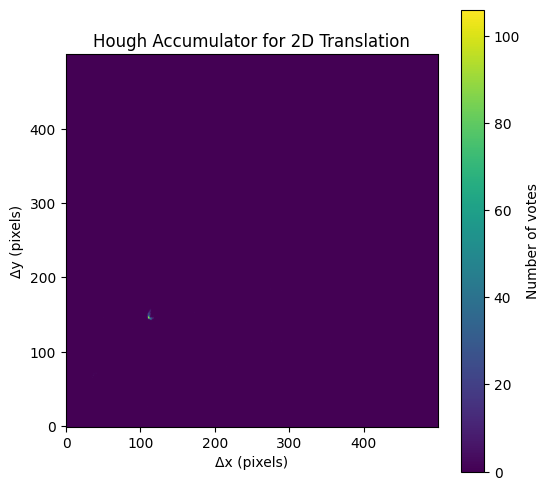

In [37]:
plt.figure(figsize=(6, 6))
plt.imshow(acc, origin='lower')
plt.title("Hough Accumulator for 2D Translation")
plt.xlabel("Δx (pixels)")
plt.ylabel("Δy (pixels)")
plt.colorbar(label="Number of votes")
plt.show()

What is the maximum value in the accumulator?

In [38]:
max_votes = acc.max()
print(f"Maximum votes in the accumulator: {max_votes}")

Maximum votes in the accumulator: 106


Print the location of the maximum value in the accumulator.  This is the dominant motion vector.

***Hint: look at ```np.where```.***

In [39]:
ys, xs = np.where(acc == max_votes)
dy_max, dx_max = ys[0], xs[0]

print(f"Dominant motion vector: (Δy, Δx) = ({dy_max}, {dx_max}) with {max_votes} votes")

Dominant motion vector: (Δy, Δx) = (147, 110) with 106 votes


**Optional challenge question:** How would you change the resolution of the Hough accumulator (the size of each grid cell)?  For example, how could you make each grid cell have a size of $2\times2$ instead of $1\times1$ as it is now?

2. Now let's use RANSAC to find the dominant motion vector.

Here is the RANSAC process for this problem, using a fixed number of iterations:

- Repeat $N$ times:
  - Select a random motion vector from the list of motion vectors.  This is your "model."
  - Evaluate all motion vectors against the model using Euclidean distance.
  - Classify each motion vector as an inlier or outlier using a threshold of $\tau$.
  - Count the number of inliers.
- Keep the model with the highest number of inliers.

Use $N=1000$ and $\tau=5$.

I provided for you here a function to get the list of inliers for a motion vector, and a function to count the number of inliers.

After running RANSAC, print out the model with the most inliers, and show a plot of the inliers to that model.

*Hint: look at ```np.random.randint``` or ```np.random.choice``` for random sampling.*

In [40]:
def get_inliers(vec,inlier_thresh=5):
    errs = np.sqrt( (vecs[:,0]-vec[0])**2 + (vecs[:,1]-vec[1])**2 )
    inliers = errs<inlier_thresh
    return inliers

def count_inliers(vec,inlier_thresh=5):
    inliers = get_inliers(vec,inlier_thresh)
    return np.count_nonzero(inliers)

In [41]:
N = 1000
tau = 5

best_vec = None
best_count = 0
best_inliers = None

for _ in range(N):
    idx = np.random.randint(len(vecs))
    model = vecs[idx]

    mask = get_inliers(model, inlier_thresh=tau)
    count = count_inliers(model, inlier_thresh=tau)

    if count > best_count:
        best_count = count
        best_vec = model
        best_inliers = mask

dy, dx = best_vec
print(f"Best motion vector found: (Δy, Δx) = ({dy}, {dx}) with {best_count} inliers")

Best motion vector found: (Δy, Δx) = (148, 112) with 1308 inliers


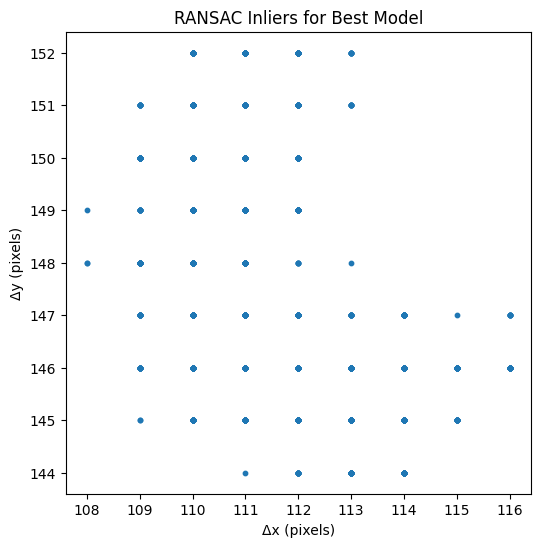

In [42]:
inlier_vecs = vecs[best_inliers]
dy_in = inlier_vecs[:, 0]
dx_in = inlier_vecs[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(dx_in, dy_in, s=10)
plt.xlabel("Δx (pixels)")
plt.ylabel("Δy (pixels)")
plt.title("RANSAC Inliers for Best Model")
plt.show()